In [1]:
import os
import re

In [2]:
!pip install pandas
!pip install matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install sqlalchemy

In [5]:
from sqlalchemy import create_engine

# TASK 1

Defining the connection params for connecting to the Postgresql DB

In [6]:
HOST = "localhost"
DB = "tweetsDB"
USER = "postgres"
PASSWD = "passwd"

Assemblying the db connection string

In [7]:
posgres_conn_str = f"postgresql://{USER}:{PASSWD}@{HOST}/{DB}"

In [8]:
engine = create_engine(posgres_conn_str)

# TASK 2

Adding the sentiment columns to the tweets table

In [126]:
add_columns_query = """

    ALTER TABLE tweets
    ADD COLUMN neg numeric(6, 4),
    ADD COLUMN neu numeric(6, 4),
    ADD COLUMN pos numeric(6, 4),
    ADD COLUMN compound numeric(6, 4)

"""

In [127]:
with engine.connect() as connection:    
    with connection.begin():
        connection.execute(add_columns_query)

In [9]:
HASHTAG_FILTER = """'%%DeepstateVirus%%', '%%DeepStateVaccine%%','%%DeepStateFauci%%', '%%QAnon%%', '%%Agenda21%%', '%%CCPVirus%%', '%%ClimateChangeHoax%%',
'%%GlobalWarmingHoax%%', '%%ChinaLiedPeopleDied%%', '%%SorosVirus%%', '%%5GCoronavirus%%', '%%MAGA%%',
'%%WWG1WGA%%', '%%Chemtrails%%', '%%flatEarth%%', '%%MoonLandingHoax%%', '%%moonhoax%%', '%%illuminati%%',
'%%pizzaGateIsReal%%', '%%PedoGateIsReal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"""

In [10]:
# hashtag : conspiracy_theory
CONSPIRACY_THEORIES = {
 
        "deepstatevirus"                :   "Deep State",  
        "deepstatevaccine"              :   "Deep State",
        "deepstatefauci"                :   "Deep State",
        "qanon"                         :   "Qanon",
        "maga"                          :   "Qanon",
        "wwg1wga"                       :   "Qanon",
        "agenda21"                      :   "New world order",
        "ccpvirus"                      :   "The virus escaped from a Chinese lab", 
        "chinaliedpeopledied"           :   "The virus escaped from a Chinese lab",
        "climatechangehoax"             :   "GLobal Warming is HOAX",
        "globalwarminghoax"             :   "GLobal Warming is HOAX",
        "sorosvirus"                    :   "COVID19 and microchipping", 
        "billgates"                     :   "COVID19 and microchipping",
        "5gcoronavirus"                 :   "COVID19 is preaded by 5G",
        "moonlandinghoax"               :   "Moon landing is fake", 
        "moonhoax"                      :   "Moon landing is fake",
        "911truth"                      :   "9/11 was inside job",
        "911insidejob"                  :   "9/11 was inside job",
        "pizzagateisreal"               :   "Pizzagate conspiracy theory",
        "pedogateisreal"                :   "Pizzagate conspiracy theory",   
        "chemtrails"                    :   "Chemtrails",
        "flatearth"                     :   "FlatEarth",
        "illuminati"                    :   "Illuminati",
        "reptilians"                    :   "Reptilian conspiracy theory"
}

We need to match all the mutations of the hashtags:

In [130]:
filter_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array[{HASHTAG_FILTER.lower()}])
"""

In [131]:
filter_query

"\n    SELECT * \n    FROM hashtags\n    WHERE lower(value) LIKE ANY (array['%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'])\n"

In [132]:
qanon_query = f"""
    SELECT * 
    FROM hashtags
    WHERE lower(value) LIKE ANY (array['qanon'])
"""

In [133]:
df_qanon = pd.read_sql(qanon_query, engine)

In [134]:
df_filtered = pd.read_sql(filter_query, engine)

The filter matches 2018 hashtags

In [135]:
len(df_filtered)

2018

In [136]:
df_qanon

,id,value
0,16070849,qaNON
1,15168832,QANOn
2,15170088,qaNon
3,15856421,qAnoN
4,15752301,QANon
5,15189267,QAnoN
6,15274024,QaNON
7,16204212,QaNon
8,18149870,qanoN
9,16342002,QaNoN


We can see that hoaxer dont know grammar

Next we define our emoji and regex pattern filter to filter the content of the tweet from hashtags, mentions and other metacharacters.

In [137]:
emoji_pat = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        # u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        # u"\U00002702-\U000027B0"
        # u"\U000024C2-\U0001F251"  # mandarinian chars
        u"\U00010000-\U0010ffff"
        u"\U0001f926-\U0001f937"
        u"\u2600-\u2B55"
        u"\u2640-\u2642" 
        u"\u200d"
        u"\u231a"
        u"\u23e9"
        u"\u23cf"
        u"\ufe0f"  # dingbats
        u"\u3030"
                        "]+", flags = re.UNICODE)



# returns the parsed line using the regex that strips away the # and @
def parse_line(line):
    res = re.sub("[#@]+[\w.-]*", "", line)
    res = emoji_pat.sub(r'',res)
    return res.lstrip().rstrip()

In [139]:
import nltk
import numpy as np
!pip install tqdm
from tqdm import tqdm
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# 2152424 / 100 ~= 21524
chunk_offset = 100

def compute_sentiment_and_write2(dataframe):
    # parse the lines and compute the sentiment

    with engine.connect() as connection:
        for chunk in tqdm(np.array_split(dataframe, chunk_offset)):
            # begin the transaction
            with connection.begin():
                for index, line in chunk.iterrows():
                    id = line['tweetid']
                    sentiment = sid.polarity_scores(parse_line(line['content']))                
                    connection.execute(f"""
                    UPDATE tweets
                        SET neg = {sentiment['neg']},
                            neu = {sentiment['neu']},
                            pos = {sentiment['pos']},
                            compound = {sentiment['compound']}
                        WHERE id = '{id}';""")
                        



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kdeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
lower_hastag_filter = HASHTAG_FILTER.lower()

In [12]:
lower_hastag_filter

"'%%deepstatevirus%%', '%%deepstatevaccine%%','%%deepstatefauci%%', '%%qanon%%', '%%agenda21%%', '%%ccpvirus%%', '%%climatechangehoax%%',\n'%%globalwarminghoax%%', '%%chinaliedpeopledied%%', '%%sorosvirus%%', '%%5gcoronavirus%%', '%%maga%%',\n'%%wwg1wga%%', '%%chemtrails%%', '%%flatearth%%', '%%moonlandinghoax%%', '%%moonhoax%%', '%%illuminati%%',\n'%%pizzagateisreal%%', '%%pedogateisreal%%', '%%911truth%%', '%%911insidejob%%', '%%reptilians%%'"

In [142]:
query = f"""
                SELECT tweets.id as tweetID, tweets.content, h.id as hashtagID, h.value as hashtagVal
                FROM tweets
                JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
                JOIN hashtags as h ON h.id = th.hashtag_id
                WHERE lower(h.value) ILIKE ANY (array[{lower_hastag_filter}])
        
"""

Get all the tweets that match the hashtag filter

In [143]:
df_filtered_tweets = pd.read_sql(query, engine)

In [144]:
len(df_filtered_tweets)

3656142

We can see the parsing method in action.

In [145]:
df_filtered_tweets['content'][20]

'Killing the Coronavirus: Dr. Anthony Fauci on what’s being done to stop a worldwide pandemic. #AmericaFirst #MAGA #Dobbs https://t.co/izTQnSCEWR'

In [146]:
parse_line(df_filtered_tweets['content'][20])

'Killing the Coronavirus: Dr. Anthony Fauci on what’s being done to stop a worldwide pandemic.    https://t.co/izTQnSCEWR'

In [147]:
df_filtered_tweets['hashtagval'] = df_filtered_tweets['hashtagval'].apply(lambda x: x.lower()) 

Remove duplicates

In [148]:
df_unique_filtered_tweets = df_filtered_tweets.drop_duplicates(subset=['tweetid'])

In [149]:
df_filtered_tweets.head(15)

,tweetid,content,hashtagid,hashtagval
0,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
1,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
2,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
3,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
4,1220796147759026176,🛑 Gateway Pundit News 🛑 \n\n👉 Senator Tom Cott...,14415,maga
5,1220795094326005760,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
6,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
7,1220498546492956672,"@Jordan_Sather_ Halo!, please find the unroll ...",20506,qanon
8,1220792996582645760,Insightful essay on the Chinese Coronavirus.\n...,24818,maga
9,1220792996582645760,Insightful essay on the Chinese Coronavirus.\n...,20506,qanon


In [150]:
df_unique_filtered_tweets.head(15)

,tweetid,content,hashtagid,hashtagval
0,1220786014006009856,Update: #Coronavirus Is Spreading In The US No...,14415,maga
1,1220789297474916355,@being_nontheist @SenatorDurbin @Lawrence @Sen...,18287,wwg1wga_worldwide
2,1220796328265101312,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
3,1220491726214717440,I didn't say a word about #QAnon in my tweets ...,20506,qanon
4,1220796147759026176,🛑 Gateway Pundit News 🛑 \n\n👉 Senator Tom Cott...,14415,maga
5,1220795094326005760,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
6,1220797748502417409,RT @Jordan_Sather_: I didn't say a word about ...,20506,qanon
7,1220498546492956672,"@Jordan_Sather_ Halo!, please find the unroll ...",20506,qanon
8,1220792996582645760,Insightful essay on the Chinese Coronavirus.\n...,24818,maga
10,1220793089318584320,RT @jaazee1: Insightful essay on the Chinese C...,24818,maga


In [151]:
len(df_unique_filtered_tweets)

2152424

Computing the sentiment and writing it to the db

In [152]:
compute_sentiment_and_write2(df_unique_filtered_tweets)

100%|██████████| 100/100 [24:04<00:00, 14.44s/it]


# TASK 3

Creating the consp_theory tables as well the link between hashtags and consptheory

In [154]:
consp_theory_link = df_filtered_tweets.loc[ : , ["hashtagid", "hashtagval", "tweetid"]]

In [155]:
len(consp_theory_link)

3656142

In [156]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,18287,wwg1wga_worldwide,1220789297474916355
2,20506,qanon,1220796328265101312
3,20506,qanon,1220491726214717440
4,14415,maga,1220796147759026176
5,20506,qanon,1220795094326005760
6,20506,qanon,1220797748502417409
7,20506,qanon,1220498546492956672
8,24818,maga,1220792996582645760
9,20506,qanon,1220792996582645760


In [157]:
consp_theory_link[consp_theory_link['tweetid'] == str(1256801279139069952)]

,hashtagid,hashtagval,tweetid
18522,20506,qanon,1256801279139069952
18523,15171991,chemtrails,1256801279139069952
18525,25089,wwg1wga,1256801279139069952
18527,259500,wwg1wgaworldwide,1256801279139069952


In [158]:
consp_theory_link = consp_theory_link.drop_duplicates(subset=['hashtagid'])

In [159]:
len(consp_theory_link)

2018

In [160]:
consp_theory_link = consp_theory_link.reset_index(drop=True)

In [161]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid
0,14415,maga,1220786014006009856
1,18287,wwg1wga_worldwide,1220789297474916355
2,20506,qanon,1220796328265101312
3,24818,maga,1220792996582645760
4,25089,wwg1wga,1220791787255750656
5,25091,qanon,1219860725440503809
6,27195,qanon,1220790900324020224
7,33792,chemtrails,1220415227394695170
8,59789,magats,1220983070372831232
9,29024,qanons,1220577746696462342


Get the name of the consp. theory.

In [13]:
CONSPIRACY_THEORIES_LIST = list(CONSPIRACY_THEORIES.keys())
THEORY_LIST = list(set(CONSPIRACY_THEORIES.values()))

def chceck_theory(hashtag):
    for key in CONSPIRACY_THEORIES_LIST:
        if key in hashtag:
            return CONSPIRACY_THEORIES.get(key)


Mapping the hashtag to the theory name.

In [163]:
consp_theory_link['theory'] = consp_theory_link.apply(lambda x: chceck_theory(x['hashtagval']), axis=1)

In [164]:
consp_theory_link.head(10)

,hashtagid,hashtagval,tweetid,theory
0,14415,maga,1220786014006009856,Qanon
1,18287,wwg1wga_worldwide,1220789297474916355,Qanon
2,20506,qanon,1220796328265101312,Qanon
3,24818,maga,1220792996582645760,Qanon
4,25089,wwg1wga,1220791787255750656,Qanon
5,25091,qanon,1219860725440503809,Qanon
6,27195,qanon,1220790900324020224,Qanon
7,33792,chemtrails,1220415227394695170,Chemtrails
8,59789,magats,1220983070372831232,Qanon
9,29024,qanons,1220577746696462342,Qanon


Creating the conspiracy theory table

In [165]:
id_arr = [x for x in range(1, len(THEORY_LIST) + 1)]

In [166]:
consp_theory_tab = pd.DataFrame(list(zip(id_arr, THEORY_LIST)), columns=["id", "theory_name"])

In [167]:
consp_theory_tab

,id,theory_name
0,1,Pizzagate conspiracy theory
1,2,FlatEarth
2,3,9/11 was inside job
3,4,Reptilian conspiracy theory
4,5,Qanon
5,6,The virus escaped from a Chinese lab
6,7,New world order
7,8,COVID19 is preaded by 5G
8,9,GLobal Warming is HOAX
9,10,Illuminati


Schema for the table

In [168]:
with engine.connect() as connection:    
    with connection.begin():
        connection.execute("""
            CREATE TABLE IF NOT EXISTS consp_theories (
            id INT GENERATED ALWAYS AS IDENTITY,
            theory_name varchar(255),
            PRIMARY KEY(id)
            );   
    """)

Inserting the consp_theories

In [170]:
with engine.connect() as connection:
    with connection.begin():
        for _, row in consp_theory_tab.iterrows():
            engine.execute(f"""
                
                INSERT INTO consp_theories(theory_name)
                VALUES ('{row['theory_name']}');
                
            """)

In [171]:
df_theories = pd.read_sql(
    """
    SELECT id, theory_name
    FROM 
    consp_theories
    """
    , engine)

In [172]:
df_theories

,id,theory_name
0,1,Pizzagate conspiracy theory
1,2,FlatEarth
2,3,9/11 was inside job
3,4,Reptilian conspiracy theory
4,5,Qanon
5,6,The virus escaped from a Chinese lab
6,7,New world order
7,8,COVID19 is preaded by 5G
8,9,GLobal Warming is HOAX
9,10,Illuminati


Creating a dictionary to map the conspiracy theories to the hashtags via the conspiracy theory id

In [173]:
mapping_dict = dict(zip(df_theories['theory_name'], df_theories['id']))

In [174]:
mapping_dict

{'Pizzagate conspiracy theory': 1,
 'FlatEarth': 2,
 '9/11 was inside job': 3,
 'Reptilian conspiracy theory': 4,
 'Qanon': 5,
 'The virus escaped from a Chinese lab': 6,
 'New world order': 7,
 'COVID19 is preaded by 5G': 8,
 'GLobal Warming is HOAX': 9,
 'Illuminati': 10,
 'Moon landing is fake': 11,
 'Chemtrails': 12,
 'Deep State': 13,
 'COVID19 and microchipping': 14}

Creating a new column and adding the mapping

In [175]:
consp_theory_link['theory_id'] = consp_theory_link.apply(lambda x: mapping_dict.get(x['theory']), axis=1)

In [176]:
consp_theory_link

,hashtagid,hashtagval,tweetid,theory,theory_id
0,14415,maga,1220786014006009856,Qanon,5
1,18287,wwg1wga_worldwide,1220789297474916355,Qanon,5
2,20506,qanon,1220796328265101312,Qanon,5
3,24818,maga,1220792996582645760,Qanon,5
4,25089,wwg1wga,1220791787255750656,Qanon,5
...,...,...,...,...,...
2013,37283281,magamisinformation,1244668722163351556,Qanon,5
2014,37295422,inkedmagazine,1248276196112175104,Qanon,5
2015,37375431,blomaga,1253872845890842624,Qanon,5
2016,37408594,magadumb,1258858634899009538,Qanon,5


In [177]:
hash_consp_mapping = consp_theory_link.loc[:, ['hashtagid', 'theory_id']]

In [178]:
hash_consp_mapping = hash_consp_mapping.drop_duplicates(subset=['hashtagid'])

In [179]:
hash_consp_mapping.dtypes

hashtagid    int64
theory_id    int64
dtype: object

In [180]:
hash_consp_mapping.head(15)

,hashtagid,theory_id
0,14415,5
1,18287,5
2,20506,5
3,24818,5
4,25089,5
5,25091,5
6,27195,5
7,33792,12
8,59789,5
9,29024,5


In [181]:
hash_consp_mapping['hashtagid'] = hash_consp_mapping['hashtagid'].astype(int)
hash_consp_mapping = hash_consp_mapping.dropna()
hash_consp_mapping['theory_id'] = hash_consp_mapping['theory_id'].astype(int)

In [182]:
hash_consp_mapping.head(15)

,hashtagid,theory_id
0,14415,5
1,18287,5
2,20506,5
3,24818,5
4,25089,5
5,25091,5
6,27195,5
7,33792,12
8,59789,5
9,29024,5


Adding the mapping table between theories and hashtags

In [183]:
with engine.connect() as connection:
        with connection.begin():
            connection.execute("""
                CREATE TABLE IF NOT EXISTS hash_consptheories_link (
                id int GENERATED ALWAYS AS IDENTITY,
                hashtag_id int,
                consp_theory_id int,
                PRIMARY KEY(id),
                CONSTRAINT fk_hashtag
                    FOREIGN KEY(hashtag_id)
                        REFERENCES hashtags(id)
                        ON DELETE SET NULL,

                CONSTRAINT fk_consptheory        
                    FOREIGN KEY(consp_theory_id)
                        REFERENCES consp_theories(id)
                        ON DELETE SET NULL
            );  
            """)

Filling the mapping table

In [185]:
with engine.connect() as connection:
    with connection.begin():
        for _, row in hash_consp_mapping.iterrows():
            # print(row['theory_name'])
            engine.execute(f"""
                
                INSERT INTO hash_consptheories_link(hashtag_id, consp_theory_id)
                VALUES ('{int(row['hashtagid'])}', '{int(row['theory_id'])}');
                
            """)

# TASK 4

The subselect gets us the tweets with extreme sentiment and their corresponding conspiracy theory name, extracted week in which the tweet was created and also by the compound and the neutral sentiment of the tweet. The outer select computes mainly the agregate average of the compound and neutral sentiment values of the tweets over the week it was created, then groups them by the week and the theory it belongs to. At last the result is ordered by the theory. 

In [24]:
sentiment_query = """

    SELECT res.theory, res.week, count(res.week) as tweet_count, avg(abs(res.compound)) as tweet_extreme_count, avg(abs(res.neu)) as tweet_neutral_count
    FROM 
    (
	SELECT ct.theory_name as theory, EXTRACT(WEEK from tweets.happened_at) as week, tweets.compound, tweets.neu
		FROM tweets
		JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
		JOIN hashtags as h ON h.id = th.hashtag_id
		JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
		JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
		WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
			) as res
        
    GROUP BY (res.week, res.theory)
    ORDER BY res.theory


"""

In [25]:
df_week_extreme_comp = pd.read_sql(sentiment_query, engine)

In [26]:
df_week_extreme_comp.head(15)

,theory,week,tweet_count,tweet_extreme_count,tweet_neutral_count
0,9/11 was inside job,5.0,3,0.557400,0.662000
1,9/11 was inside job,8.0,1,0.648600,0.654000
2,9/11 was inside job,15.0,7,0.642800,0.793000
3,9/11 was inside job,16.0,3,0.586767,0.728333
4,9/11 was inside job,18.0,6,0.734700,0.708667
5,9/11 was inside job,19.0,2,0.736600,0.740500
6,9/11 was inside job,22.0,15,0.629927,0.857933
7,COVID19 and microchipping,8.0,4,0.620275,0.830250
8,COVID19 is preaded by 5G,13.0,1,0.790600,0.759000
9,COVID19 is preaded by 5G,14.0,22,0.741805,0.617045


In [27]:
df_week_extreme_comp['week'] = df_week_extreme_comp['week'].astype(int)

Showing the results


    #######
    ---  Qanon  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    1            2             0.825250             0.668500
    2            5             0.739720             0.821200
    3            7             0.747843             0.763714
    4          493             0.678748             0.731071
    5          959             0.680131             0.704304
    6          295             0.690514             0.697692
    7          348             0.690929             0.678813
    8          199             0.669348             0.695442
    9          825             0.725291             0.689878
   11            4             0.725550             0.705000
   12            8             0.750225             0.710125
   13           15             0.668187             0.781867
   14        57665             0.699644             0.708481
   15       170705             0.694327             0.727771
   16       169432             0.7049

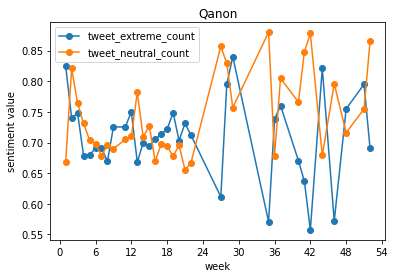


    #######
    ---  New world order  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    4           69             0.762917             0.693116
    5          280             0.765642             0.690575
    6           19             0.689605             0.740789
    7           15             0.637400             0.778067
    8            3             0.774733             0.698000
    9            3             0.667533             0.686000
   13            1             0.983700             0.378000
   14           16             0.756819             0.659500
   15           24             0.653692             0.754333
   16           27             0.637437             0.686481
   17           15             0.641320             0.689267
   18          122             0.801818             0.569770
   19           13             0.631177             0.718231
   20           28             0.622254             0.420643
   21           29         

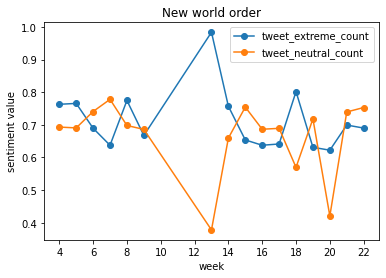


    #######
    ---  9/11 was inside job  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    5            3             0.557400             0.662000
    8            1             0.648600             0.654000
   15            7             0.642800             0.793000
   16            3             0.586767             0.728333
   18            6             0.734700             0.708667
   19            2             0.736600             0.740500
   22           15             0.629927             0.857933


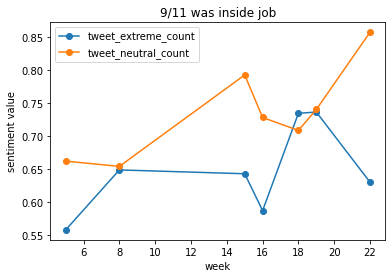


    #######
    ---  Chemtrails  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    4            6             0.723550             0.693333
    5            7             0.703371             0.706857
    6            2             0.735450             0.675500
   14           19             0.719563             0.728632
   15           22             0.646909             0.815636
   16           53             0.717664             0.652925
   17           20             0.649535             0.718550
   18           18             0.659739             0.774222
   19           12             0.736308             0.749833
   20           13             0.672792             0.663615
   21           21             0.708438             0.754143
   22           14             0.703714             0.816929


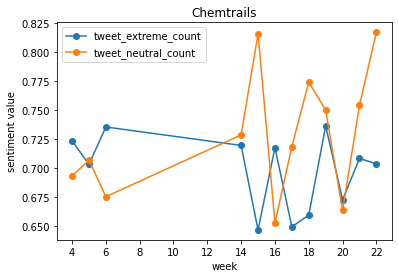


    #######
    ---  GLobal Warming is HOAX  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    5            7             0.766743                0.699
    6            5             0.680960                0.569
    8            1             0.850400                0.776
    9            1             0.750600                0.841
   20            3             0.604767                0.855


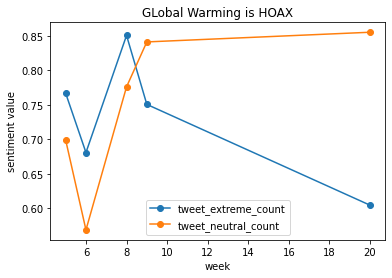


    #######
    ---  Reptilian conspiracy theory  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
   15            1             0.541100             0.889000
   16           13             0.630877             0.642000
   17            7             0.590371             0.699571
   18            4             0.576100             0.773250


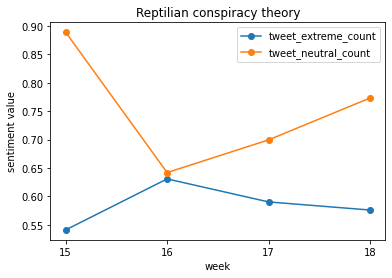


    #######
    ---  Moon landing is fake  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
   16            1              0.52670               0.7930
   19            3              0.52670               0.7930
   20           10              0.61174               0.7486
   21            1              0.63300               0.7360
   22            2              0.63300               0.7360


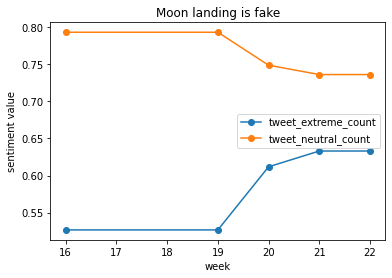


    #######
    ---  Deep State  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
   14           71             0.551000             0.752592
   15           61             0.729587             0.652262
   16            3             0.650667             0.569333
   17            4             0.693300             0.680000
   18            9             0.811244             0.718111
   20            3             0.634733             0.816667
   22            7             0.700300             0.616000


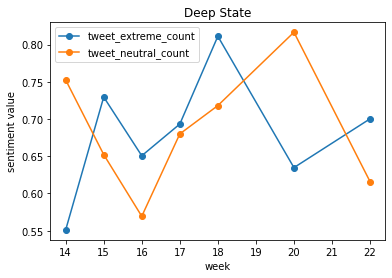


    #######
    ---  FlatEarth  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    5            8             0.742062             0.656625
    6            1             0.542300             0.791000
    7            2             0.578900             0.812000
    9            1             0.636900             0.538000
   14            4             0.701475             0.702750
   15            6             0.590417             0.795500
   16           14             0.597850             0.648571
   17            7             0.675800             0.654571
   18           15             0.711913             0.624200
   19            6             0.705817             0.718333
   20           15             0.665453             0.695400
   21           19             0.758158             0.675211
   22            6             0.710350             0.716833


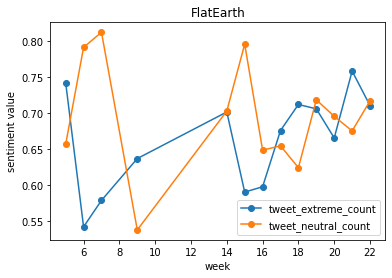


    #######
    ---  Illuminati  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    4            4             0.623500             0.821500
    5            5             0.677480             0.767600
    6            2             0.712100             0.755500
    7            1             0.778300             0.562000
    9            1             0.598300             0.770000
   14           73             0.683022             0.703137
   15           63             0.632559             0.727302
   16          129             0.685302             0.679605
   17          140             0.630960             0.749557
   18          113             0.627522             0.751124
   19           25             0.663232             0.717000
   20           51             0.659973             0.657137
   21           19             0.712316             0.621316
   22           33             0.628755             0.709455


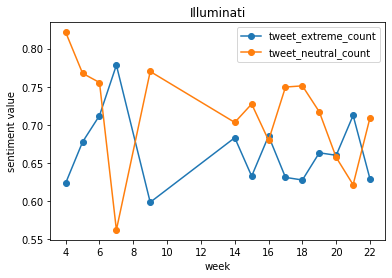


    #######
    ---  Pizzagate conspiracy theory  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    6            1             0.745600             0.635000
   13            2             0.599400             0.822000
   14           35             0.718940             0.706000
   15          115             0.675477             0.682313
   16          148             0.680988             0.665919
   17           47             0.700043             0.610596
   18          186             0.691783             0.623608
   19           28             0.699218             0.682714
   20           87             0.703439             0.642908
   21           65             0.703023             0.584108
   22           71             0.683690             0.670394
   35            1             0.570700             0.880000


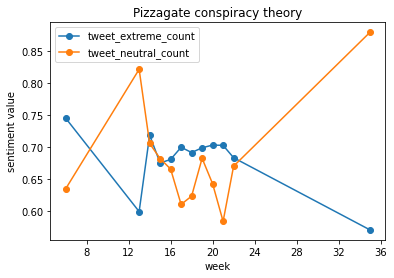


    #######
    ---  COVID19 and microchipping  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    8            4             0.620275              0.83025


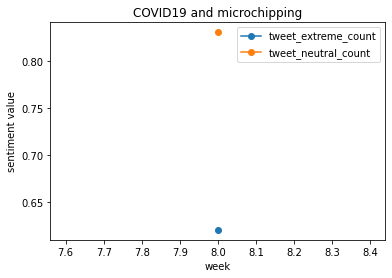


    #######
    ---  COVID19 is preaded by 5G  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
   13            1             0.790600             0.759000
   14           22             0.741805             0.617045
   15           22             0.628568             0.764000
   16           10             0.690020             0.744000
   17           20             0.695740             0.695800
   18            9             0.635733             0.725222
   19            6             0.680700             0.675833


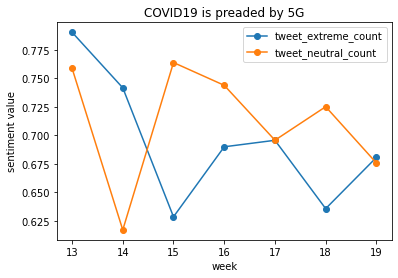


    #######
    ---  The virus escaped from a Chinese lab  ---
    ######
     week  tweet_count  tweet_extreme_count  tweet_neutral_count
    5            2             0.567750             0.781500
    6            3             0.751000             0.759333
    7            2             0.548500             0.653000
   12            5             0.721080             0.770000
   13           16             0.756925             0.702500
   14          462             0.707998             0.687398
   15          554             0.687776             0.687758
   16          547             0.684170             0.704080
   17          361             0.682989             0.711482
   18          282             0.673451             0.715461
   19          162             0.692586             0.694383
   20           77             0.721236             0.728013
   21           10             0.719480             0.580900
   22           10             0.786240             0.653900


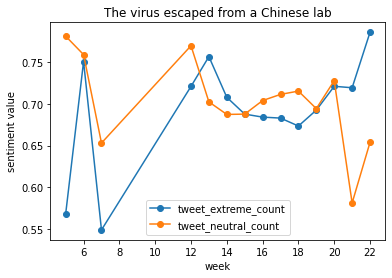

In [28]:
from matplotlib.ticker import MaxNLocator

for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name}  ---
    ######
    {df_week_extreme_comp[df_week_extreme_comp['theory'] == name].loc[: , df_week_extreme_comp.columns != 'theory'].to_string(index=False)}""")


    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


    ax.set_title(name)
  
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_extreme_count'], 'o-', label="tweet_extreme_count")
    
    plt.xlabel('week')
    plt.ylabel('sentiment value')
    
    plt.plot(df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['week'], 
        df_week_extreme_comp[df_week_extreme_comp['theory'] == name]['tweet_neutral_count'], 'o-', label="tweet_neutral_count")
    
    plt.legend()
    
    # show plot
    plt.show()
        
    

# TASK 5

To get the top 10 acounts that are most active in every consp. theory by extreme sentiment, we first join the tables connecting tweets with tweet_hashtags, tweet_hastags with hashtags, hashtags with the conspiracy theories via the link between them and we also connect the tweets with the accounts via tweet_mentions. After that we get the tweets with the extreme sentiment ( > 0.5 and < -0.5) and we group them by consp theory, account_id, account_name, account_screen_name. At last we order them by the theory in an ascending order and select the theory_nam, account_id, account_name, account_screen_name and the count of tweets that account produced.

In [191]:
accounts_query = """
    SELECT ct.theory_name, acc.id , acc.name, acc.screen_name, count(tweets.id) as tweet_count
    FROM tweets
    JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
    JOIN hashtags as h ON h.id = th.hashtag_id
    JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
    JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
    JOIN tweet_mentions as tm ON tm.tweet_id = tweets.id
    JOIN accounts as acc ON tm.account_id = acc.id
    WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
    group by (ct.theory_name, acc.id, acc.name, acc.screen_name)
    ORDER BY ct.theory_name ASC
"""

In [192]:
df_top_accounts_for_consp = pd.read_sql(accounts_query, engine)

In [193]:
df_top_accounts_for_consp.head(15)

,theory_name,id,name,screen_name,tweet_count
0,9/11 was inside job,14499829,World Health Organization (WHO),WHO,1
1,9/11 was inside job,55905770,Miriam Selmi Reed,mimiselmi,2
2,9/11 was inside job,2213750137,Madeleine Stäubli,MadeleineRodun,1
3,9/11 was inside job,1173334893104967682,Anonymous Busch,AnonymousBusch,1
4,COVID19 and microchipping,23125257,George Soros,georgesoros,1
5,COVID19 and microchipping,188363529,"Alexander Soros, PhD",AlexanderSoros,1
6,COVID19 and microchipping,192538987,O. Bula-Escobar,omarbula,3
7,COVID19 is preaded by 5G,5402612,BBC Breaking News,BBCBreaking,1
8,COVID19 is preaded by 5G,16707004,Jeff Kagan - Wireless Analyst Columnist Consul...,jeffkagan,1
9,COVID19 is preaded by 5G,18320606,Anti-Flag,anti_flag,1


We sort the results be the theory and the tweet count that account produced.

In [194]:
df_top_accounts_for_consp = df_top_accounts_for_consp.sort_values(['theory_name', 'tweet_count'], ascending=[False, False])

In [195]:
df_top_accounts_for_consp.head(15)

,theory_name,id,name,screen_name,tweet_count
3607,The virus escaped from a Chinese lab,2313027666,Jennifer Zeng 曾錚,jenniferatntd,113
3571,The virus escaped from a Chinese lab,1339488762,Solomon Yue,SolomonYue,96
3127,The virus escaped from a Chinese lab,14499829,World Health Organization (WHO),WHO,95
3223,The virus escaped from a Chinese lab,25073877,Donald J. Trump,realDonaldTrump,65
3832,The virus escaped from a Chinese lab,1232414456589750272,China in Focus - NTD,ChinaInFocusNTD,61
3405,The virus escaped from a Chinese lab,189868631,Tedros Adhanom Ghebreyesus,DrTedros,59
3768,The virus escaped from a Chinese lab,1060573081935249409,NTD News,news_ntd,59
3237,The virus escaped from a Chinese lab,29097819,The Epoch Times,EpochTimes,32
3634,The virus escaped from a Chinese lab,2775998016,Hu Xijin 胡锡进,HuXijin_GT,29
3409,The virus escaped from a Chinese lab,195271137,Larry Elder,larryelder,18


The whole results

In [196]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name}  ---
    ######
    {df_top_accounts_for_consp[df_top_accounts_for_consp['theory_name'] == name].loc[ :, ['id', 'name', 'screen_name', 'tweet_count']].head(10).to_string(index=False)}""")


    #######
    ---  Pizzagate conspiracy theory  ---
    ######
            id            name    screen_name  tweet_count
1071777608    John Podesta    johnpodesta            1
1339835893 Hillary Clinton HillaryClinton            1

    #######
    ---  FlatEarth  ---
    ######
                    id                name     screen_name  tweet_count
929387229880946688        Jack William   Jackszooquest            4
          25073877     Donald J. Trump realDonaldTrump            2
          10228272             YouTube         YouTube            1
          17471979 National Geographic          NatGeo            1
          38190348              Daniel crimescenevegas            1
          40053694    Flavio Bolsonaro FlavioBolsonaro            1
          68712576    Carlos Bolsonaro CarlosBolsonaro            1
          74756085 Eduardo Bolsonaro🇧🇷     BolsonaroSP            1
         120910874     Hidden Mountain HiddenMountain7            1
         128372940   Jair M. Bols

# TASK 6

To find the top most used hashtags for every consp theory we first join our tweets, tweet_hashtags, hashtags and conspiracy theories together, then we get the ones with the extreme sentiment and group them by the hashtag id and theory name. At last we order them in a dexcending order by the thoery name and the tweet count which represents number of distinct tweets in which the hashtags occured.

In [32]:
hash_tags_query = """
SELECT ct.theory_name, h.id , h.value as hashtag_val, count(h.id) as tweet_count
	FROM tweets
	JOIN tweet_hashtags as th ON th.tweet_id = tweets.id
	JOIN hashtags as h ON h.id = th.hashtag_id
	JOIN hash_consptheories_link as hcl ON hcl.hashtag_id = h.id
	JOIN consp_theories as ct ON ct.id = hcl.consp_theory_id
	WHERE tweets.compound NOT BETWEEN (-0.5) AND (0.5)
	group by (ct.theory_name, h.id)
	ORDER BY ct.theory_name DESC, tweet_count DESC;
"""

In [33]:
df_top_hashtags_for_consp = pd.read_sql(hash_tags_query, engine)

In [34]:
df_top_hashtags_for_consp.head(15)

,theory_name,id,hashtag_val,tweet_count
0,The virus escaped from a Chinese lab,3073063,CCPVirus,1303
1,The virus escaped from a Chinese lab,5112446,ChinaLiedPeopleDied,953
2,The virus escaped from a Chinese lab,1137275,CCPvirus,151
3,The virus escaped from a Chinese lab,10905016,ccpvirus,26
4,The virus escaped from a Chinese lab,20463352,CCPVirus_Coronavirus,24
5,The virus escaped from a Chinese lab,16685336,chinaliedpeopledied,9
6,The virus escaped from a Chinese lab,18509464,CCPVIRUS,7
7,The virus escaped from a Chinese lab,1379885,ccpVirus,3
8,The virus escaped from a Chinese lab,17257752,CCPVirusHoax,3
9,The virus escaped from a Chinese lab,33519958,CCPVirusIsReal,2


In [35]:
df_top_hashtags_for_consp['tweet_count'] = df_top_hashtags_for_consp['tweet_count'].astype(int)

In [36]:
df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == "The virus escaped from a Chinese lab"].head(10)

,theory_name,id,hashtag_val,tweet_count
0,The virus escaped from a Chinese lab,3073063,CCPVirus,1303
1,The virus escaped from a Chinese lab,5112446,ChinaLiedPeopleDied,953
2,The virus escaped from a Chinese lab,1137275,CCPvirus,151
3,The virus escaped from a Chinese lab,10905016,ccpvirus,26
4,The virus escaped from a Chinese lab,20463352,CCPVirus_Coronavirus,24
5,The virus escaped from a Chinese lab,16685336,chinaliedpeopledied,9
6,The virus escaped from a Chinese lab,18509464,CCPVIRUS,7
7,The virus escaped from a Chinese lab,1379885,ccpVirus,3
8,The virus escaped from a Chinese lab,17257752,CCPVirusHoax,3
9,The virus escaped from a Chinese lab,33519958,CCPVirusIsReal,2


The whole results

In [37]:
for name in THEORY_LIST:
    print(f"""
    #######
    ---  {name} ---
    ######
    {df_top_hashtags_for_consp[df_top_hashtags_for_consp['theory_name'] == name].loc[ :, ['hashtag_val', 'tweet_count']].head(10).to_string(index=False)}""")


    #######
    ---  Qanon ---
    ######
         hashtag_val  tweet_count
           QAnon       414929
         WWG1WGA       200135
           Qanon       128848
            MAGA        70324
           qanon        65265
           QANON        56804
WWG1WGAWORLDWIDE        33578
       QAnon2020        29701
       ObamaGate        29084
       QAnon2018        27809

    #######
    ---  New world order ---
    ######
                   hashtag_val  tweet_count
                  Agenda21          370
                  agenda21          220
                  AGENDA21           81
                UNAgenda21            6
      Depopulationagenda21            1
Agenda21TheUNplanToKillYou            1

    #######
    ---  9/11 was inside job ---
    ######
        hashtag_val  tweet_count
       911Truth           24
       911truth            8
       911Truth            2
   911insidejob            2
911insidejobber            1

    #######
    ---  Chemtrails ---
    ######
   